In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from unbalanced_cv import get_fold
#from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import networkx as nx
import data_analysis_func as func

#colorize images
import misc
import data_analysis_func as func

# Parameters

In [2]:
#"Properties Index" - Properties to be validated
# [1 = Shapes], [2 = Network], [3 = All], [4 - All and Idx], [5 = Degree]

r = 350                                # Radius to be analized
k = 3                                  # Number of neighbors for the k-nearest neighbors classifier
number_classes = 2                     # Number of classes in the dataset
number_folds = 5                       # Number of Folds

image_names = ['S07_46186 10X_20151028_59', '3']
#image_names = ['S07_46186 10X_20151028_59']

confusion_matrices = []
for name in image_names:
    p = 'prostate_marked/' + name + '/results_radius_' + str(r) + '/'
    graph = nx.read_gml(p + 'grafo_glands_properties_' + str(r) + 'r.gml')
    
    print("Image: " + name)
    g_nodes, g_nodes_demarcated = func.display_gland_numbers(graph)
    print("")
    
    N = len(g_nodes) + len(g_nodes_demarcated)
    predicted_classes = np.full(N, -1)          # Will store the classes predicted by the classifier
    
    confusion_matrix = {
    "Image Name": name,
    "Radius": r,
    "Path": p,
    "Path Mask RGB": 'prostate_marked/' + name + '/MASK - RGB.png',
    "Mask RGB": None,
    "Path Result Class Color": p + '/results_colorize/img_colored_two_classes.png',
    "Graph": graph,
    "Health Nodes": g_nodes,
    "Unhealth Nodes": g_nodes_demarcated,
    "Properties To Analyze": [
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 1,
            "Properties Description": "Shapes",
            "Properties Names": ['area', 'diameter', 'perimeter', 'eccentricity', 'solidity'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 2,
            "Properties Description": "Network",
            "Properties Names": ['degree', 'betweenness', 'strength'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 3,
            "Properties Description": "All",
            "Properties Names": ['area', 'diameter', 'perimeter', 'eccentricity', 'solidity', 'degree', 'betweenness', 'strength'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        #{
        #    "K": k,
        #    "Number of Classes": number_classes,
        #    "Number of Folds": number_folds,
        #    "Properties Index": 4,
        #    "Properties Names": ['idx', 'area', 'diameter', 'perimeter', 'eccentricity', 'solidity', 'degree', 'betweenness', 'strength'],
        #    "Table of Properites Normalized": None,
        #    "Accuracy": None,
        #    "Classes": None,
        #    "Classes Predicted": predicted_classes.copy(),
        #    "Tested Indexes": None,
        #    "Confusion Matrix":
        #       {
        #           "Data": None,
        #           "Precision": None,
        #           "Recall": None,
        #           "Specificity": None,
        #           "Accuracy": None
        #       }
        #},
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 5,
            "Properties Description": "Network Degree",
            "Properties Names": ['degree'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
    ]
    }
    
    confusion_matrices.append(confusion_matrix)

Image: S07_46186 10X_20151028_59
Number of NORMAL glands:  2240
Number of DEMARCATED glands:  1124

Image: 3
Number of NORMAL glands:  1788
Number of DEMARCATED glands:  327



In [3]:
for matrix in confusion_matrices:
    
    for prop in matrix["Properties To Analyze"]:
        table_prop_norm, c = func.get_table_properties(matrix["Graph"], prop["Properties Names"], True)
        prop["Table of Properites Normalized"] = table_prop_norm
        prop["Classes"] = c
        
        
        list_test_index = []
        list_classes_pred = []
        
        N = len(matrix["Health Nodes"]) + len(matrix["Unhealth Nodes"])

        for data_train, classes_train, data_test, classes_test, test_indices in get_fold(table_prop_norm, c, prop["Number of Folds"]):
            list_test_index.extend(test_indices)

            # Train classifier using data_train, classes_train
            clf = svm.SVC(C=500)
            clf.fit(data_train, classes_train)

            # Test classifier using data_test, classes_test
            pred = clf.predict(data_test)
            list_classes_pred.append(pred)

            # Save predictions
            prop["Classes Predicted"][test_indices] = pred

            prop["Tested Indexes"] = list_test_index
        
        # `pred_classes` can then be compared with `classes` for verifying the accuracy of the classifier
        prop["Accuracy"] = np.sum(c==prop["Classes Predicted"])/N
        print("%3.4f" % (np.sum(c==prop["Classes Predicted"])/N) + " Accuracy of \"" + matrix["Image Name"] + "\" " + prop["Properties Description"])

0.6424 Accuracy of "S07_46186 10X_20151028_59" Shapes
0.9426 Accuracy of "S07_46186 10X_20151028_59" Network
0.9379 Accuracy of "S07_46186 10X_20151028_59" All
0.9450 Accuracy of "S07_46186 10X_20151028_59" Network Degree
0.6293 Accuracy of "3" Shapes
0.9390 Accuracy of "3" Network
0.9220 Accuracy of "3" All
0.9281 Accuracy of "3" Network Degree


# Visualize Mask Glands

prostate_marked/S07_46186 10X_20151028_59/MASK - RGB.png
prostate_marked/3/MASK - RGB.png


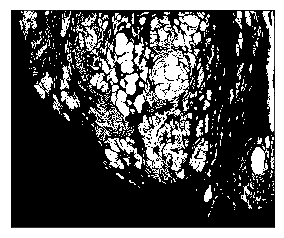

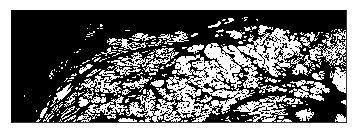

In [4]:
for matrix in confusion_matrices:
    print(matrix["Path Mask RGB"])
    #img = plt.imread(matrix["Path Mask RGB"])
    #misc.show_img(img)

    img = 255-(255*plt.imread(matrix["Path Mask RGB"])[:,:,0]).astype(np.uint8)
    misc.show_img(img)
    matrix["Mask RGB"] = img.copy()

# Colorize Classes

In [ ]:
for matrix in confusion_matrices:
    # Get Color objects color GREEN (not demarcated) and color RED (demarcated) otherwise ORANGE(undefined)
    position, class_colors, measurements = func.get_color_inputs(matrix["Graph"])

    # Get Color objects according to the colors defined in `class_colors`
    img_colored1 = func.color_objects(img, position, class_colors, print_progress=True)

    #remove black in background
    img_colored1[img_colored1==0] = 255
    
    plt.figure(figsize=(40,15))
    plt.imshow(img_colored1)
    plt.axis('off')
    plt.savefig(matrix["Path Result Class Color"], dpi=300)

# Colorize Results in each properties group

In [5]:
colorize_results = False
colorize_cross_measurements = False

for matrix in confusion_matrices:
    
    print("------")
    print(matrix["Image Name"])
    
    for prop in matrix["Properties To Analyze"]:
        position, class_colors, confusion_matrix = func.get_colors_by_pred_results_test_indices(matrix["Graph"], prop["Classes Predicted"], prop["Tested Indexes"])
        print('----------------------------------------------')
        print("{:3.4f} % Accuracy with ".format(prop["Accuracy"]) + prop["Properties Description"])
        print('----------------------------------------------')
        print('         +---------------------------------+')
        print('         |  Health Class  | Unhealth Class |')
        print('         +---------------------------------+')
        print('  Health |      ' + "{:04d}".format(confusion_matrix[0][0]) + '      |       ' + "{:04d}".format(confusion_matrix[0][1]) + '     |')
        print('         +---------------------------------+')
        print('Unhealth |      ' + "{:04d}".format(confusion_matrix[1][0]) + '      |       ' + "{:04d}".format(confusion_matrix[1][1]) + '     |')
        print('         +---------------------------------+')
        
        tn = confusion_matrix[0][0]
        fp = confusion_matrix[0][1]
        fn = confusion_matrix[1][0]
        tp = confusion_matrix[1][1]

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        true_negative_rate = tn / (tn + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        print('Precision: ' + "{:3.4f}".format(precision))
        print('Recall: ' + "{:3.4f}".format(recall))
        print('Specificity: ' + "{:3.4f}".format(true_negative_rate))
        print('Accuracy: ' + "{:3.4f}".format(accuracy))
        
        prop["Confusion Matrix"]["Data"] = confusion_matrix.copy()
        prop["Confusion Matrix"]["Precision"] = precision
        prop["Confusion Matrix"]["Recall"] = recall
        prop["Confusion Matrix"]["Specificity"] = true_negative_rate
        prop["Confusion Matrix"]["Accuracy"] = accuracy
        
        

        
        print("")
        print("")
        
        
        if colorize_results:
            colorized_img = func.color_objects(matrix["Mask RGB"], position, class_colors, print_progress=False)

            plt.figure(figsize=(40,15))
            plt.imshow(colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands.png', dpi=300)

            colorized_img[colorized_img==0] = 255

            plt.figure(figsize=(40,15))
            plt.imshow(colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands_w.png', dpi=300)
        
        
        if colorize_cross_measurements:
            position, class_colors, measurements = func.get_color_inputs(matrix["Graph"])
            colored_cross = func.color_objects(img, position, values=measurements, colormap='viridis', print_progress=False)

            plt.figure(figsize=(30,15))
            plt.imshow(colored_cross)
            cbar = plt.colorbar()
            cbar.set_label('Degree', size=16)
            cbar.ax.tick_params(labelsize=14)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colored_cross_measurements.png', dpi=300)

            #remove black in background
            colored_cross[colored_cross==0] = 255

            plt.figure(figsize=(30,15))
            plt.imshow(colored_cross)
            cbar = plt.colorbar()
            cbar.set_label(prop["Properties Description"], size=16)
            cbar.ax.tick_params(labelsize=14)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colored_cross_measurements_w.png', dpi=300)
        
    print("")
    print("")

------
S07_46186 10X_20151028_59
----------------------------------------------
0.6424 % Accuracy with Shapes
----------------------------------------------
         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      1208      |       1032     |
         +---------------------------------+
Unhealth |      0171      |       0953     |
         +---------------------------------+
Precision: 0.4801
Recall: 0.8479
Specificity: 0.5393
Accuracy: 0.6424


----------------------------------------------
0.9426 % Accuracy with Network
----------------------------------------------
         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      2143      |       0097     |
         +---------------------------------+
Unhealth |      0096      |       1028     |
         +---------------------------------+
Precision: 0.913

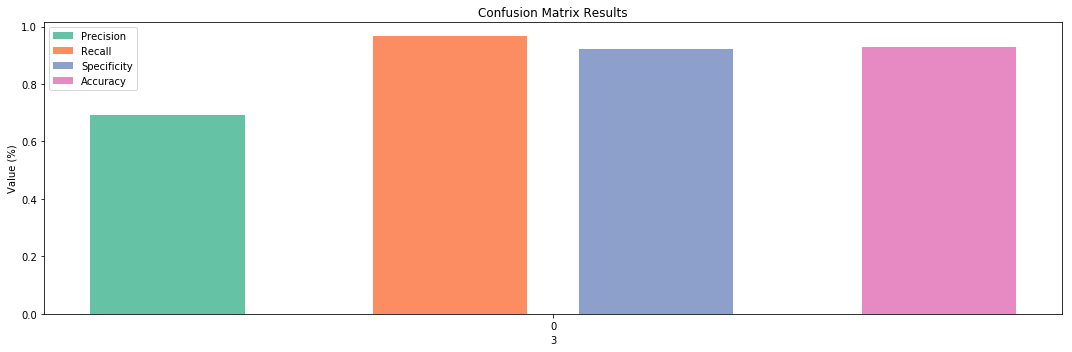

In [6]:
x = np.arange(1)  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))

rects3 = ax.bar(x - (2.5*width), precision, width, label='Precision', color= ( np.array((102,194,165)) / 255 ) )
rects1 = ax.bar(x - width/1.5, recall, width, label='Recall', color= ( np.array((252,141,98)) / 255 ))

rects2 = ax.bar(x + width/1.5, true_negative_rate, width, label='Specificity', color= ( np.array((141,160,203)) / 255 ))
rects4 = ax.bar(x + (2.5*width), accuracy, width, label='Accuracy', color= ( np.array((231,138,195)) / 255 ))


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value (%)')
ax.set_title('Confusion Matrix Results')
ax.set_xticks(x)
ax.set_xlabel(confusion_matrices[1]["Image Name"])
ax.legend()


fig.tight_layout()

plt.savefig(confusion_matrices[1]["Path"] + 'confusion_matrix.png', dpi=300)
plt.show()



In [7]:
data_confusion_matrix = {}
for p in ["Shapes", "Network", "All", "Network Degree"]:
    data_confusion_matrix[p] = { 
            "Precision": [],
            "Recall": [],
            "Specificity": [],
            "Accuracy": []
        }

for matrix in confusion_matrices:
    
    img_name    = confusion_matrices[0]["Image Name"]
    
    i = 1
    
    for prop in matrix["Properties To Analyze"]:
        data_cm = data_confusion_matrix[prop["Properties Description"]]
        
        data_cm["Precision"].append( prop["Confusion Matrix"]["Precision"] )
        data_cm["Recall"].append( prop["Confusion Matrix"]["Recall"] )
        data_cm["Specificity"].append( prop["Confusion Matrix"]["Specificity"] )
        data_cm["Accuracy"].append( prop["Confusion Matrix"]["Accuracy"] )


print(data_confusion_matrix)


{'Shapes': {'Precision': [0.4801007556675063, 0.26988922457200404], 'Recall': [0.847864768683274, 0.8195718654434251], 'Specificity': [0.5392857142857143, 0.5945190156599552], 'Accuracy': [0.6423900118906064, 0.6293144208037825]}, 'Network': {'Precision': [0.9137777777777778, 0.7270642201834863], 'Recall': [0.9145907473309609, 0.9694189602446484], 'Specificity': [0.9566964285714286, 0.9334451901565995], 'Accuracy': [0.942627824019025, 0.9390070921985816]}, 'All': {'Precision': [0.89748045178106, 0.6745689655172413], 'Recall': [0.9190391459074733, 0.9571865443425076], 'Specificity': [0.9473214285714285, 0.9155480984340044], 'Accuracy': [0.937871581450654, 0.9219858156028369]}, 'Network Degree': {'Precision': [0.9173333333333333, 0.6914660831509847], 'Recall': [0.9181494661921709, 0.9663608562691132], 'Specificity': [0.9584821428571428, 0.9211409395973155], 'Accuracy': [0.9450059453032105, 0.9281323877068558]}}


[Text(0,0,'Precision'),
 Text(0,0,'Recall'),
 Text(0,0,'Specificity'),
 Text(0,0,'Accuracy')]

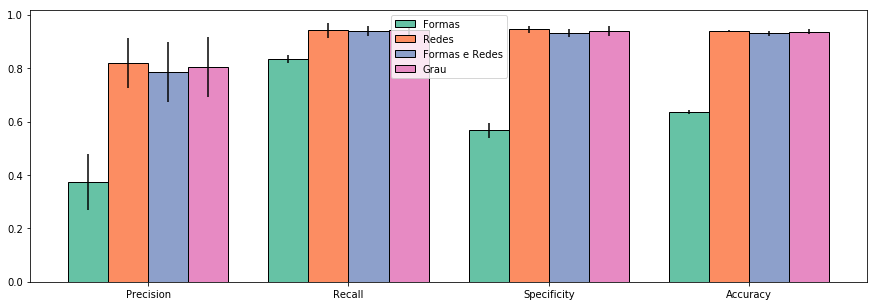

In [8]:
dx = 0.1 #distance between each set of 4 bars, wich is 2 * dx
bw = (1 - 2 * dx) / 4 # width of each bin
bw2 = bw / 2

colors = [np.array((102,194,165)) / 255, np.array((252,141,98)) / 255, 
        np.array((141,160,203)) / 255, np.array((231,138,195)) / 255]

fig, ax = plt.subplots(figsize=(15,5))

for meas_idx, (meas_keys, meas_values) in enumerate(data_confusion_matrix.items()):
    for perf_idx, (perf_keys, perf_values) in enumerate(meas_values.items()):
        
        avg = np.mean(perf_values)
        std_dev = np.std(perf_values)
        
        if perf_idx == 0:
            label = meas_keys
        else:
            label = None
        
        if label == 'Shapes':
            label = 'Formas'
        elif label == 'Network':
            label = 'Redes'
        elif label == 'All':
            label = 'Formas e Redes'
        elif label == 'Network Degree':
            label = 'Grau'
            
        x = perf_idx + dx + bw2 + meas_idx * bw
        bar = plt.bar(x, avg, yerr=std_dev, width = bw, label = label, color = colors[meas_idx], edgecolor = 'k')

plt.legend()
ax.set_xticks(np.arange(.5, 4, 1))
ax.set_xticklabels(list( list(data_confusion_matrix.values())[0].keys() ))


In [9]:
for meas_idx, (meas_keys, meas_values) in enumerate(data_confusion_matrix.items()):
    print(meas_keys)
    print('Accuracy' + str(meas_values['Accuracy']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Accuracy'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Accuracy'])) + ']')
    print('----')
    print('Precision' + str(meas_values['Precision']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Precision'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Precision'])) + ']')
    print('----')
    print('Recall' + str(meas_values['Recall']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Recall'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Recall'])) + ']')
    print('----')
    print('Specificity' + str(meas_values['Specificity']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Specificity'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Specificity'])) + ']')
    print('----')
        
    print('')
    print('')
    print('')
    print('')

Shapes
Accuracy[0.6423900118906064, 0.6293144208037825]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.6358522163471945]
StdDev[0.0065377955434119395]
----
Precision[0.4801007556675063, 0.26988922457200404]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.3749949901197552]
StdDev[0.10510576554775114]
----
Recall[0.847864768683274, 0.8195718654434251]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.8337183170633495]
StdDev[0.01414645161992445]
----
Specificity[0.5392857142857143, 0.5945190156599552]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.5669023649728347]
StdDev[0.027616650687120492]
----




Network
Accuracy[0.942627824019025, 0.9390070921985816]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.9408174581088034]
StdDev[0.0018103659102217118]
----
Precision[0.9137777777777778, 0.7270642201834863]
Images['S07_46186 10X_20151028_59', '3']
Avg[0.820420998980632]
StdDev[0.09335677879714577]
----
Recall[0.9145907473309609, 0.9694189602446484]
Images['S07_46186 10X_20151028_59', '3']
Avg[0